[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/main.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Анализ датасета Chinese Traffic Signs
https://www.kaggle.com/datasets/dmitryyemelyanov/chinese-traffic-signs

Датасет содержит каталог с изображениями и файл с аннотацией annotations.csv

In [2]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'


In [3]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet152
from sklearn import metrics
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

#import cv2

### Train

In [4]:
ChineseTS = pd.read_csv(os.path.join(dataset_path, 'ChineseTS', 'annotations.csv'))
for i in range(len(ChineseTS)):
    ChineseTS.loc[i, 'file_name'] = 'images/' + ChineseTS.loc[i, 'file_name']
ChineseTS

,file_name,width,height,x1,y1,x2,y2,category
0,images/000_0001.png,134,128,19,7,120,117,0
1,images/000_0002.png,165,151,23,12,149,138,0
2,images/000_0003.png,128,122,22,14,116,105,0
3,images/000_0010.png,80,73,14,8,67,63,0
4,images/000_0011.png,186,174,36,15,155,157,0
...,...,...,...,...,...,...,...,...
6159,images/056_1_0018_1_j.png,122,94,25,20,80,79,56
6160,images/056_1_0019_1_j.png,224,207,39,39,188,178,56
6161,images/056_1_0020_1_j.png,128,115,32,30,89,79,56
6162,images/057_1_0001_1_j.png,100,95,21,22,74,75,57


Сопоставим классы

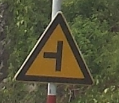

In [16]:
class_id = 44
index = 1
df_temp = ChineseTS[ChineseTS['category'] == class_id].copy()
df_temp.reset_index(inplace=True)
img_name = df_temp.loc[index, 'file_name']
Image.open(os.path.join(dataset_path, 'ChineseTS', img_name))

Расшифровка знаков
- 0 - ограничение максимальной скорости (5)         3_24
- 1 - ограничение максимальной скорости (15)        3_24
- 2 - ограничение максимальной скорости (30)        3_24
- 3 - ограничение максимальной скорости (40)        3_24
- 4 - ограничение максимальной скорости (50)        3_24
- 5 - ограничение максимальной скорости (60)        3_24
- 6 - ограничение максимальной скорости (70)        3_24
- 7 - ограничение максимальной скорости (80)        3_24
- 8 - прямо и налево запрещено
- 9 - прямо и направо запрещено
- 10 - прямо запрещено
- 11 - Поворот налево запрещен                      3_18_2
- 12 - налево и направо запрещено
- 13 - Поворот направо запрещен                     3_18
- 14 - объезд запрещен
- 15 - разворот запрещен                            3_19
- 16 - движение механических транспортных средств запрещено
- 17 - Подача звукового сигнала запрещена
- 18 - Конец ограничения скорости (40)              3_25
- 19 - Конец ограничения скорости (50)              3_25
- 20 - Движение прямо и направо                     4_1_4
- 21 - Движение прямо                               4_1_1
- 22 - Движение налево                              4_1_3
- 23 - Движение направо или налево                  4_1_6
- 24 - Движение направо                             4_1_2
- 25 - Объезд слева                                 4_2_2
- 26 - Объезд справа                                4_2_1
- 27 - Круговое движение                            4_3
- 28 - Дорога для автомобилей (не похоже)           5_3
- 29 - Звуковой сигнал?
- 30 - Велосипедная зона?
- 31 - Место для разворота                          6_3_1
- 32 - Объезд с 2 сторон??
- 33 - Светофор                                     1_8
- 34 - Осторожно (только желтый)                    1_33
- 35 - Пешеходный переход (желтый)                  1_22
- 36 - Осторожно велосипедисты (в российских нет)
- 37 - Дети (не похож)                              1_23
- 38 - Странный объезд?
- 39 - Странный объезд?
- 40 - Спуск?
- 41 - Подъем?
- 42 - Иероглифы
- 43 - Примыкание второстепенной дороги (справа)+-  2_3_2
- 44 - Примыкание второстепенной дороги (слева) +-  2_3_3
- 45 - Дом отдыха?
- 46 - Зигзаги
- 47 - Железнодорожный переезд без шлагбаума +-     1_2
- 48 - Дорожные работы                              1_25
- 49 - Зигзиги
- 50 - Железнодорожный переезд со шлагбаумом +-     1_1
- 51 - ??
- 52 - Иероглифы
- 53 - движение запрещено на квадратном фоне
- 54 - Остановка запрещена                          3_27
- 55 - Въезд запрещен (кирпич)                      3_1
- 56 - Иероглифы
- 57 - Видимо таможня и иероглифами

Распределение частот появления классов в обучающей выборке

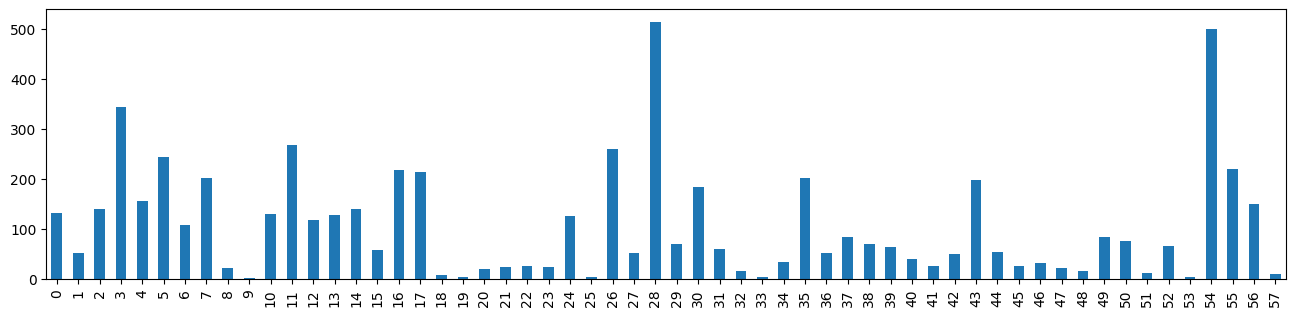

In [89]:
Train_counts = pd.Series(data = ChineseTS.value_counts(['category']).sort_index())
Train_counts.index = range(58)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax = Train_counts.plot(kind='bar')
fig.set_size_inches(16,3.5)
plt.show()

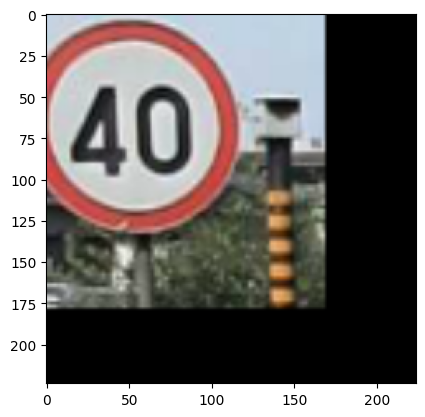

In [93]:
image_id = 116
x1 = ChineseTS.loc[image_id, 'x1']
y1 = ChineseTS.loc[image_id, 'y1']
x2 = ChineseTS.loc[image_id, 'x2']
y2 = ChineseTS.loc[image_id, 'y2']
bbox = [x1, y1, x2, y2]
img = Image.open(os.path.join(dataset_path, 'ChineseTS', ChineseTS.loc[image_id, 'file_name'])).crop(bbox)
transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()
                                    ])   
img = transform(img)
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

### Обучение классификатора на датасете ChineseTS (без аугментации)

Загрузчик данных

In [97]:
class GTSRB_dataset_classifier(Dataset):
    def __init__(self, dataset_path, anno, transforms, crop = False):
        
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.df_dataset = pd.read_csv(os.path.join(dataset_path, 'ChineseTS', anno))
        self.crop = crop

    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        img = Image.open(os.path.join(self.dataset_path, 'ChineseTS', 'images', img_name))

        if self.crop == True:
            x1 = self.df_dataset.loc[index, 'x1']
            y1 = self.df_dataset.loc[index, 'y1']
            x2 = self.df_dataset.loc[index, 'x2']
            y2 = self.df_dataset.loc[index, 'y2']
            bbox = [x1, y1, x2, y2]
            img = img.crop(bbox)
        img = self.transforms(img)

        label = torch.tensor(self.df_dataset.loc[index,'category'])
        
        return {'images':img, 'labels':label}

def get_transform(): 
    return transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               ])   

In [98]:
test = GTSRB_dataset_classifier(dataset_path,
                                anno = 'annotations.csv',
                                transforms = get_transform(),
                                crop = True)
test.__getitem__(2)['images'].shape

torch.Size([3, 224, 224])

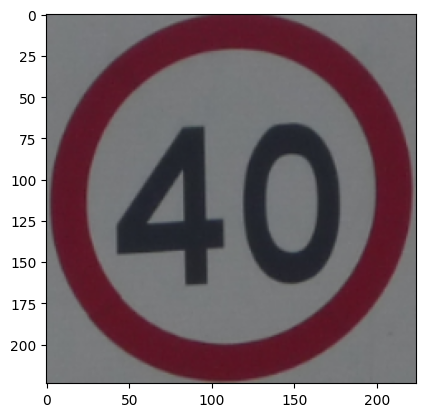

In [101]:
image_id = 121
img = test.__getitem__(image_id)['images']
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

Гиперпараметры

In [103]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

model_name = 'ChineseTS_resnet152_adam_001'
last_epoch = None
n_epochs = 5
batch_size = 32
num_classes = 58

device

'cuda:0'

Инициализация модели, задание оптимизатора и функции потерь

In [104]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False 
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

In [109]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = GTSRB_dataset_classifier(dataset_path,
                                         anno = 'annotations.csv',
                                         transforms = get_transform(),
                                         crop = False)

'''val_dataset = GTSRB_dataset_classifier(dataset_path,
                                       anno = 'BelgiumTSC_test.csv',
                                       transforms = get_transform(),
                                       crop = False)'''

train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               )

'''val_data_loader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=False
                             )'''

'val_data_loader = DataLoader(val_dataset,\n                             batch_size=batch_size,\n                             shuffle=False\n                             )'

In [106]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader} on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [107]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx} is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader} is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [110]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    #val_losses = checkpoint['losses_val']
    train_accuracies = checkpoint['accuracies_train']
    #val_accuracies = checkpoint['accuracies_val']
    train_f1_micros = checkpoint['train_f1_micro']
    #val_f1_micros = checkpoint['val_f1_micro']
    train_f1_macros = checkpoint['train_f1_macro']
    #val_f1_macros = checkpoint['val_f1_macro']
    train_f1_weighteds = checkpoint['train_f1_weighted']
    #val_f1_weighteds = checkpoint['val_f1_weighted']
else:
    train_losses = []
    #val_losses = []
    train_accuracies = []
    #val_accuracies = []
    train_f1_micros = []
    #val_f1_micros = []
    train_f1_macros = []
    #val_f1_macros = []
    train_f1_weighteds = []
    #val_f1_weighteds = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        val_loss = 0
        #val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        #val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        #val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        #val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        #val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    #'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    #'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    #'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    #'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    #'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 4.101667404174805
4.101667404174805
Epoch #0. Accuracy on batch 0/193 on Training is 0.0
Epoch #0. Accuracy on batch 1/193 on Training is 3.125
Epoch #0. Accuracy on batch 2/193 on Training is 6.25
Epoch #0. Accuracy on batch 3/193 on Training is 10.15625
Epoch #0. Accuracy on batch 4/193 on Training is 10.625
Epoch #0. Accuracy on batch 5/193 on Training is 10.416666666666666
Epoch #0. Accuracy on batch 6/193 on Training is 9.821428571428571
Epoch #0. Accuracy on batch 7/193 on Training is 10.15625
Epoch #0. Accuracy on batch 8/193 on Training is 12.152777777777779
Epoch #0. Accuracy on batch 9/193 on Training is 13.75
Epoch #0. Accuracy on batch 10/193 on Training is 13.920454545454545
Epoch #0. Accuracy on batch 11/193 on Training is 14.583333333333334
Epoch #0. Accuracy on batch 12/193 on Training is 15.384615384615385
Epoch #0. Accuracy on batch 13/193 on Training is 16.741071428571427
Epoch #0. Accuracy on batch 14/193 on Training is 17.70833

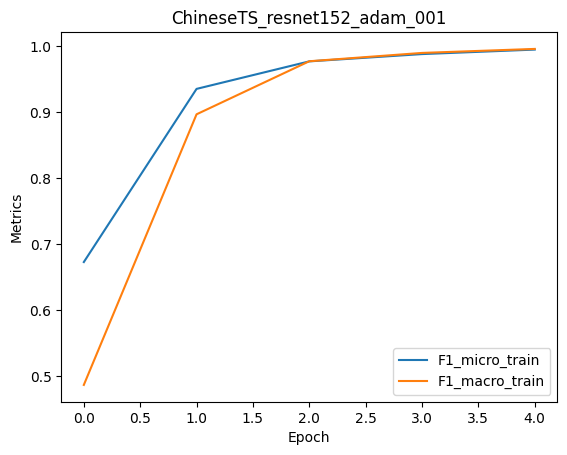

In [112]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
#ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
#ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
plt.show()